In [ ]:
# Install Ultralytics and dependencies
!pip install ultralytics

  Using cached ultralytics-8.3.79-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [ ]:
# Import required libraries
from ultralytics import YOLO
import os
import cv2
from tqdm import tqdm
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths for dataset
dataset_path = "/content/drive/MyDrive/WAID.v1i.yolov9"  # Main dataset directory
train_images_path = os.path.join(dataset_path, "train/images")
val_images_path = os.path.join(dataset_path, "valid/images")
test_images_path = os.path.join(dataset_path, "test/images")
preprocessed_path = "/content/preprocessed_data"

In [ ]:
# Create directory for preprocessed data
os.makedirs(preprocessed_path, exist_ok=True)

In [ ]:
import os
import cv2
from tqdm import tqdm

# Function to preprocess images
def preprocess_images(input_path, output_path, img_size=(640, 640)):
    """
    Preprocess images: resize and normalize.
    Args:
        input_path (str): Path to the folder containing raw images.
        output_path (str): Path to save preprocessed images.
        img_size (tuple): Target size for resizing (width, height).
    """
    os.makedirs(output_path, exist_ok=True)
    for img_name in tqdm(os.listdir(input_path), desc=f"Preprocessing {input_path}"):
        img_path = os.path.join(input_path, img_name)
        if img_name.endswith(('.jpg', '.png', '.jpeg')):  # Check for valid image extensions
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_resized = cv2.resize(img, img_size)
            img_normalized = img_resized / 255.0
            cv2.imwrite(os.path.join(output_path, img_name), (img_normalized * 255).astype('uint8'))

# Now call the function
preprocess_images(train_images_path, os.path.join(preprocessed_path, "train"))
preprocess_images(val_images_path, os.path.join(preprocessed_path, "valid"))
preprocess_images(test_images_path, os.path.join(preprocessed_path, "test"))

Preprocessing /content/drive/MyDrive/WAID.v1i.yolov9/train/images: 100%|██████████| 7071/7071 [04:28<00:00, 26.34it/s]
Preprocessing /content/drive/MyDrive/WAID.v1i.yolov9/valid/images: 100%|██████████| 2035/2035 [01:05<00:00, 31.17it/s]
Preprocessing /content/drive/MyDrive/WAID.v1i.yolov9/test/images: 100%|██████████| 1034/1034 [00:30<00:00, 34.26it/s]


In [ ]:
# Update paths in the YAML file
dataset_yaml = "/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml"

In [ ]:
# Load YOLOv9 model
model = YOLO('yolov9m.pt')

100%|██████████| 39.1M/39.1M [00:00<00:00, 159MB/s]


In [ ]:
# Train YOLOv9 model with optimized hyperparameters
results = model.train(
    data=dataset_yaml,        # Path to dataset YAML
    epochs=30,                # More epochs for better learning
    batch=16,                 # Increased batch size for stability (adjust based on GPU memory)
    imgsz=640,                # Image size
    lr0=0.005,                # Reduced initial learning rate
    lrf=0.1,                  # Lower final learning rate fraction
    optimizer='AdamW',        # AdamW optimizer for efficient updates
    momentum=0.937,           # Momentum (default, works well)
    weight_decay=0.001,       # Increased L2 regularization
    patience=5,               # Reduced patience to prevent overfitting
    augment=True,             # Enable data augmentation
    cache=True,               # Cache images for faster training
    workers=8,                # Number of workers for data loading
    project="/content/trained_model",  # Directory to save model logs and weights
    name="yolov9_optimized",  # Experiment name
    val=True,                 # Enable validation during training
    fliplr=0.5,               # Horizontal flip augmentation
    flipud=0.3,               # Reduced vertical flip to prevent excessive distortions
    mosaic=0.7,               # Reduced mosaic augmentation
    mixup=0.3,                # Reduced mixup to prevent unrealistic training images
    copy_paste=0.3,           # Reduced copy-paste augmentation
    hsv_h=0.015,              # Hue augmentation
    hsv_s=0.6,                # Reduced saturation to avoid unnatural color shifts
    hsv_v=0.3,                # Lowered brightness change
    degrees=5.0,              # Lowered rotation for more realistic training
    translate=0.1,            # Minor translations
    scale=0.3,                # Reduced scale augmentation
    shear=1.0,                # Reduced shear distortion
    perspective=0.0005,       # Lowered perspective augmentation
    cls=0.5                   # Class loss weight (adjust if needed)
)

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9m.pt, data=/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml, epochs=30, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/trained_model, name=yolov9_optimized, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1    171648  ultralytics.nn.modules.block.RepNCSPELAN4    [64, 128, 128, 64, 1]         
  3                  -1  1    276960  ultralytics.nn.modules.block.AConv           [128, 240]                    
  4                  -1  1    629520  ultralytics.nn.modules.block.RepNCSPELAN4    [240, 240, 240, 120, 1]       
  5                  -1  1    778320  ultralytics.nn.modules.block.AConv           [240, 360]                    
  6                  -1  1   1414080  ultralytics.nn.modules.block.RepNCSPELAN4    [360, 360, 360, 180, 1]       
  7                  -1  1   1556160  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.2MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/WAID.v1i.yolov9/train/labels.cache... 7071 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7071/7071 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/WAID.v1i.yolov9/train/images/DJI_0043_MOV-43_jpg.rf.516997ce12cc62f8e3bd1aade796afdd.jpg: 1 duplicate labels removed


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (7.6GB RAM): 100%|██████████| 7071/7071 [01:43<00:00, 68.57it/s] 


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/WAID.v1i.yolov9/valid/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (2.2GB RAM): 100%|██████████| 2035/2035 [00:07<00:00, 278.62it/s]


Plotting labels to /content/trained_model/yolov9_optimized/labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.937) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.001), 155 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/trained_model/yolov9_optimized
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.24G       2.03      1.394       1.51        166        640: 100%|██████████| 442/442 [05:07<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:23<00:00,  1.30s/it]


                   all       2035      32558      0.691       0.19      0.205     0.0846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      9.31G       1.95      1.179      1.466        318        640: 100%|██████████| 442/442 [05:01<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]


                   all       2035      32558      0.393      0.216      0.203     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.42G      1.879      1.079      1.428        289        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]


                   all       2035      32558      0.429      0.449      0.363      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.98G      1.842      1.039      1.406        252        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.80it/s]


                   all       2035      32558      0.653      0.429      0.522      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       9.1G       1.79     0.9614      1.373        302        640: 100%|██████████| 442/442 [04:57<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]


                   all       2035      32558      0.694      0.471      0.524       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.34G      1.772     0.9328      1.365        149        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


                   all       2035      32558      0.638      0.564      0.595      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.86G      1.751     0.9003      1.348        244        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


                   all       2035      32558      0.663      0.578      0.621        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      9.17G      1.718      0.875      1.332        214        640: 100%|██████████| 442/442 [04:57<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


                   all       2035      32558      0.685      0.599      0.639      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.68G      1.703     0.8647      1.321        239        640: 100%|██████████| 442/442 [04:57<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


                   all       2035      32558      0.699       0.64      0.683      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.18G      1.685     0.8299       1.31        294        640: 100%|██████████| 442/442 [04:57<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


                   all       2035      32558      0.719      0.663      0.713      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       8.9G      1.667     0.8103      1.297        241        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


                   all       2035      32558      0.652      0.664      0.703      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      9.02G       1.66     0.8082        1.3        273        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


                   all       2035      32558      0.763        0.7      0.752      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.48G      1.639     0.7918      1.285        221        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


                   all       2035      32558      0.781       0.63      0.729      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.83G      1.623     0.7756      1.276        350        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


                   all       2035      32558      0.784      0.738      0.788      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.71G      1.622     0.7765      1.276        225        640: 100%|██████████| 442/442 [04:57<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


                   all       2035      32558        0.8      0.716       0.78      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.95G      1.607     0.7627      1.267        233        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


                   all       2035      32558      0.776      0.718       0.77       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.73G      1.589     0.7399      1.255        194        640: 100%|██████████| 442/442 [04:57<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]


                   all       2035      32558      0.786      0.752      0.802      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.91G      1.574     0.7371      1.248        216        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]


                   all       2035      32558      0.804      0.764       0.82       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.39G      1.567     0.7248      1.246        198        640: 100%|██████████| 442/442 [04:57<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]

                   all       2035      32558      0.839      0.766      0.833      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.73G      1.559     0.7204      1.238        310        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]

                   all       2035      32558      0.844      0.777      0.841      0.476


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.18G      1.483     0.7003      1.232        166        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]

                   all       2035      32558       0.83      0.794      0.839       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.15G      1.454     0.6673      1.217        336        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]

                   all       2035      32558      0.864      0.815      0.865      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.15G      1.441     0.6471      1.209        316        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]

                   all       2035      32558      0.878      0.822      0.883      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.22G      1.435     0.6384      1.204        328        640: 100%|██████████| 442/442 [04:59<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]

                   all       2035      32558      0.876      0.845      0.891      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       8.2G      1.423     0.6219      1.198        203        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]

                   all       2035      32558      0.902      0.845        0.9      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.22G      1.405      0.613      1.186        158        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]

                   all       2035      32558      0.893      0.848        0.9      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.22G      1.396     0.6032      1.181        229        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]

                   all       2035      32558      0.911      0.855      0.911      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      8.16G      1.396        0.6       1.18        157        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]

                   all       2035      32558      0.911      0.861      0.911      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      8.17G      1.373     0.5821      1.174        116        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.83it/s]

                   all       2035      32558      0.906      0.862      0.911      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.15G      1.369     0.5767      1.169        200        640: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.84it/s]

                   all       2035      32558      0.924      0.866      0.923      0.565



30 epochs completed in 2.812 hours.
Optimizer stripped from /content/trained_model/yolov9_optimized/weights/last.pt, 40.8MB
Optimizer stripped from /content/trained_model/yolov9_optimized/weights/best.pt, 40.8MB

Validating /content/trained_model/yolov9_optimized/weights/best.pt...
Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9m summary (fused): 151 layers, 20,018,053 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:12<00:00,  1.13s/it]


                   all       2035      32558      0.897      0.856      0.913      0.555
               camelus        102        839      0.846      0.751      0.846      0.443
                cattle        638       8666      0.915      0.924      0.959      0.603
              elephant         49        338      0.971          1      0.994      0.759
                 kiang         98        626      0.815      0.703      0.793      0.367
                  seal        486       3431      0.925      0.969      0.981      0.655
                 sheep        572      17893      0.916      0.962      0.973        0.6
                 zebra         90        765      0.887      0.684      0.844      0.459
Speed: 0.2ms preprocess, 29.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/trained_model/yolov9_optimized


In [ ]:
# Save the best model path
training_dir = "/content/trained_model/yolov9_training"  # Update with the actual directory path from your training setup
best_model_path = os.path.join(training_dir, "weights", "best.pt")  # Best weights file
print("Training completed. Best model saved at:", best_model_path)

Training completed. Best model saved at: /content/trained_model/yolov9_training/weights/best.pt


In [ ]:
# Validate the model on validation set
val_results = model.val(imgsz=640, conf=0.25, iou=0.45)  # Validate with confidence threshold of 0.25
print("Validation Results:", val_results)

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9m summary (fused): 151 layers, 20,018,053 parameters, 0 gradients, 76.5 GFLOPs


val: Scanning /content/drive/MyDrive/WAID.v1i.yolov9/valid/labels.cache... 2035 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2035/2035 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (2.2GB RAM): 100%|██████████| 2035/2035 [00:07<00:00, 276.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [02:13<00:00,  1.04s/it]


                   all       2035      32558      0.919       0.88      0.927      0.594
               camelus        102        839      0.856      0.795      0.872      0.486
                cattle        638       8666      0.945      0.934      0.965      0.641
              elephant         49        338      0.985          1      0.994      0.785
                 kiang         98        626      0.847      0.738      0.827      0.418
                  seal        486       3431      0.928      0.974      0.979      0.682
                 sheep        572      17893      0.972      0.961      0.978      0.634
                 zebra         90        765      0.902      0.756      0.874       0.51
Speed: 0.3ms preprocess, 59.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/trained_model/yolov9_optimized2
Validation Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.uti

In [ ]:
# Test the model on test set with Test-Time Augmentation (TTA)
test_results = model.predict(
    source="/content/preprocessed_data/test",  # Path to your preprocessed test images
    imgsz=640,           # Image size
    conf=0.25,           # Confidence threshold
    iou=0.45,            # IoU threshold for NMS
    save=True,           # Save predictions
    save_txt=True,       # Save predictions in YOLO text format
    augment=True         # Enable Test-Time Augmentation (TTA)
)
print("Testing completed. Predictions saved.")



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1034 /content/preprocessed_data/test/044c082a-69df-47fc-ad8b-25dd39603966_jpg.rf.dab3bb42d08579a4affdd332fdbc2869.jpg: 640x640 9 cattles, 138.9ms
image 2/1034 /content/preprocessed_data/test/076e81ab-feea-4248-99b6-8d3ef5723c67_jpg.rf.ca3afd7475bb0ed696a1b945f7875a30.jpg: 640x640 7 cattles, 69.4ms
image 3/1034 /content/preprocessed_data/test/07a3a98e-4cb5-4d44-9ccf-7679913317ee_jpg.rf.2c4cf481e9b0347e14f9e9d07daab910.jpg: 640x640 5 cattles, 67.

In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/drive/MyDrive/WAID.v1i.yolov9/test/images/15b13702-ca3a-420e-aebe-6aa341d79ced_jpg.rf.a8fd72040a9ae994175fb54e539f6bc5.jpg: 640x640 17 cattles, 40.2ms
Speed: 3.0ms preprocess, 40.2ms inference, 385.4ms postprocess per image at shape (1, 3, 640, 640)


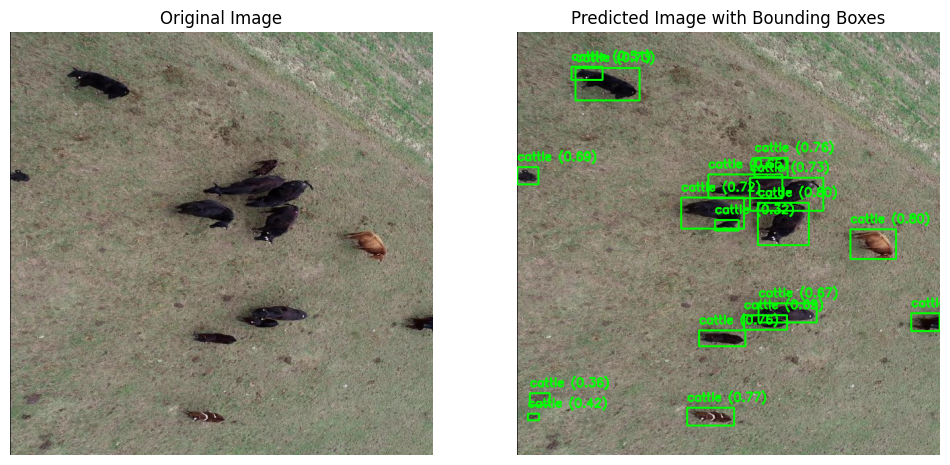

In [3]:
# Import required libraries
import cv2
import os
import yaml
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths for the trained model and test image
trained_model_path = "/content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/weights/best.pt"
test_image_path = "/content/drive/MyDrive/WAID.v1i.yolov9/test/images/15b13702-ca3a-420e-aebe-6aa341d79ced_jpg.rf.a8fd72040a9ae994175fb54e539f6bc5.jpg"
dataset_yaml_path = "/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml"

# Load class names from the dataset YAML file
with open(dataset_yaml_path, "r") as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
class_names = yaml_data["names"]

# Load YOLOv9 model
model = YOLO(trained_model_path)

# Function to preprocess an image
def preprocess_image(image_path, img_size=(640, 640)):
    """
    Preprocess the input image: resize and normalize.
    Args:
        image_path (str): Path to the image.
        img_size (tuple): Target size for resizing (width, height).
    Returns:
        preprocessed_img (numpy array): Preprocessed image.
        original_img (numpy array): Original image.
    """
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Image not found at {image_path}")

    # Convert BGR to RGB
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image
    img_resized = cv2.resize(original_img, img_size)
    preprocessed_img = img_resized / 255.0  # Normalize to [0,1]

    return preprocessed_img, original_img

# Function to visualize predictions
def visualize_predictions(original_img, predictions):
    """
    Visualize predictions on the original image.
    Args:
        original_img (numpy array): Original image.
        predictions (list): List of predictions from YOLO model.
    """
    img_with_boxes = original_img.copy()

    for pred in predictions:
        x1, y1, x2, y2 = map(int, pred["box"])  # Bounding box coordinates
        class_idx = int(pred["class_idx"])
        confidence = pred["confidence"]
        label = class_names[class_idx]  # Get class name

        # Draw bounding box
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label and confidence score
        text = f"{label} ({confidence:.2f})"
        cv2.putText(img_with_boxes, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_boxes)
    plt.title("Predicted Image with Bounding Boxes")
    plt.axis("off")

    plt.show()

# Preprocess the test image
preprocessed_img, original_img = preprocess_image(test_image_path)

# Run inference on the test image
results = model.predict(
    source=test_image_path,  # Use correct variable
    imgsz=640,               # Ensure the correct image size
    conf=0.25,               # Confidence threshold
    iou=0.45,                # IoU threshold for NMS
    device=0                 # Use GPU (set to "cpu" for CPU inference)
)

# Parse predictions
predictions = []
for result in results[0].boxes:
    predictions.append({
        "box": result.xyxy[0].tolist(),        # Bounding box coordinates
        "class_idx": int(result.cls[0].item()),  # Class index
        "confidence": float(result.conf[0].item())  # Confidence score
    })

# Visualize predictions
visualize_predictions(original_img, predictions)


image 1/1 /content/drive/MyDrive/WAID.v1i.yolov9/test/images/DJI_0004_0257_jpg.rf.e157de37a2b5a825f3a2afb5c48d0cac.jpg: 640x640 18 sheeps, 40.3ms
Speed: 3.1ms preprocess, 40.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


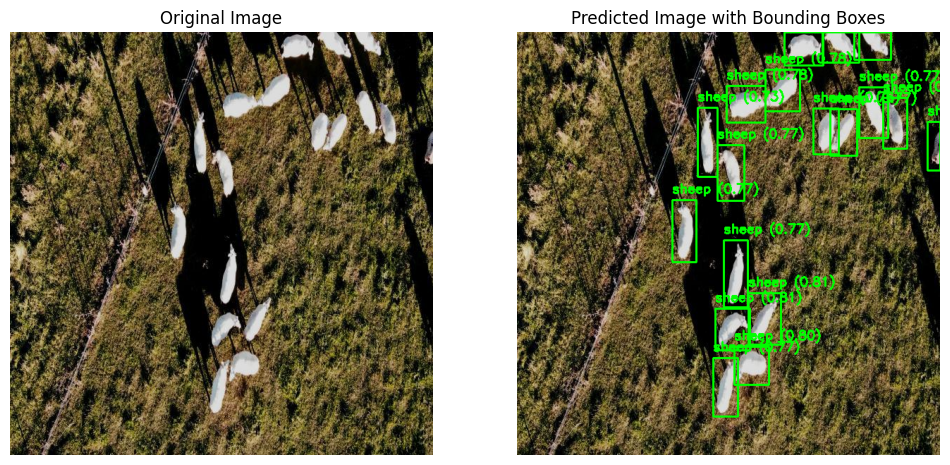

In [4]:
# Import required libraries
import cv2
import os
import yaml
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths for the trained model and test image
trained_model_path = "/content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/weights/best.pt"
test_image_path = "/content/drive/MyDrive/WAID.v1i.yolov9/test/images/DJI_0004_0257_jpg.rf.e157de37a2b5a825f3a2afb5c48d0cac.jpg"
dataset_yaml_path = "/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml"

# Load class names from the dataset YAML file
with open(dataset_yaml_path, "r") as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
class_names = yaml_data["names"]

# Load YOLOv9 model
model = YOLO(trained_model_path)

# Function to preprocess an image
def preprocess_image(image_path, img_size=(640, 640)):
    """
    Preprocess the input image: resize and normalize.
    Args:
        image_path (str): Path to the image.
        img_size (tuple): Target size for resizing (width, height).
    Returns:
        preprocessed_img (numpy array): Preprocessed image.
        original_img (numpy array): Original image.
    """
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Image not found at {image_path}")

    # Convert BGR to RGB
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image
    img_resized = cv2.resize(original_img, img_size)
    preprocessed_img = img_resized / 255.0  # Normalize to [0,1]

    return preprocessed_img, original_img

# Function to visualize predictions
def visualize_predictions(original_img, predictions):
    """
    Visualize predictions on the original image.
    Args:
        original_img (numpy array): Original image.
        predictions (list): List of predictions from YOLO model.
    """
    img_with_boxes = original_img.copy()

    for pred in predictions:
        x1, y1, x2, y2 = map(int, pred["box"])  # Bounding box coordinates
        class_idx = int(pred["class_idx"])
        confidence = pred["confidence"]
        label = class_names[class_idx]  # Get class name

        # Draw bounding box
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label and confidence score
        text = f"{label} ({confidence:.2f})"
        cv2.putText(img_with_boxes, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_boxes)
    plt.title("Predicted Image with Bounding Boxes")
    plt.axis("off")

    plt.show()

# Preprocess the test image
preprocessed_img, original_img = preprocess_image(test_image_path)

# Run inference on the test image
results = model.predict(
    source=test_image_path,  # Use correct variable
    imgsz=640,               # Ensure the correct image size
    conf=0.25,               # Confidence threshold
    iou=0.45,                # IoU threshold for NMS
    device=0                 # Use GPU (set to "cpu" for CPU inference)
)

# Parse predictions
predictions = []
for result in results[0].boxes:
    predictions.append({
        "box": result.xyxy[0].tolist(),        # Bounding box coordinates
        "class_idx": int(result.cls[0].item()),  # Class index
        "confidence": float(result.conf[0].item())  # Confidence score
    })

# Visualize predictions
visualize_predictions(original_img, predictions)


image 1/1 /content/drive/MyDrive/WAID.v1i.yolov9/test/images/a8frame00001278_jpg.rf.9c190fd24e594bad74faad83cc3f80eb.jpg: 384x640 7 cameluss, 68.2ms
Speed: 2.3ms preprocess, 68.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


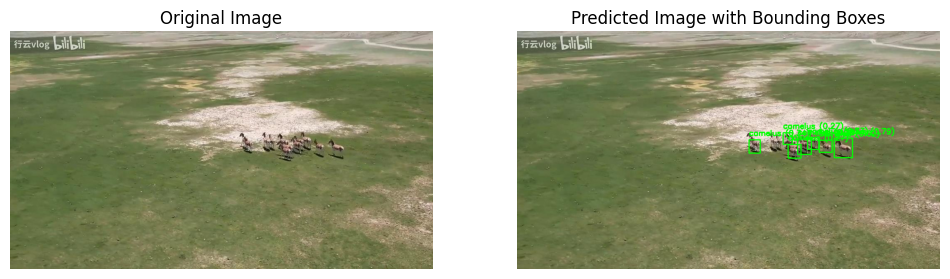

In [5]:
# Import required libraries
import cv2
import os
import yaml
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths for the trained model and test image
trained_model_path = "/content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/weights/best.pt"
test_image_path = "/content/drive/MyDrive/WAID.v1i.yolov9/test/images/a8frame00001278_jpg.rf.9c190fd24e594bad74faad83cc3f80eb.jpg"
dataset_yaml_path = "/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml"

# Load class names from the dataset YAML file
with open(dataset_yaml_path, "r") as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
class_names = yaml_data["names"]

# Load YOLOv9 model
model = YOLO(trained_model_path)

# Function to preprocess an image
def preprocess_image(image_path, img_size=(640, 640)):
    """
    Preprocess the input image: resize and normalize.
    Args:
        image_path (str): Path to the image.
        img_size (tuple): Target size for resizing (width, height).
    Returns:
        preprocessed_img (numpy array): Preprocessed image.
        original_img (numpy array): Original image.
    """
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Image not found at {image_path}")

    # Convert BGR to RGB
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image
    img_resized = cv2.resize(original_img, img_size)
    preprocessed_img = img_resized / 255.0  # Normalize to [0,1]

    return preprocessed_img, original_img

# Function to visualize predictions
def visualize_predictions(original_img, predictions):
    """
    Visualize predictions on the original image.
    Args:
        original_img (numpy array): Original image.
        predictions (list): List of predictions from YOLO model.
    """
    img_with_boxes = original_img.copy()

    for pred in predictions:
        x1, y1, x2, y2 = map(int, pred["box"])  # Bounding box coordinates
        class_idx = int(pred["class_idx"])
        confidence = pred["confidence"]
        label = class_names[class_idx]  # Get class name

        # Draw bounding box
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label and confidence score
        text = f"{label} ({confidence:.2f})"
        cv2.putText(img_with_boxes, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_boxes)
    plt.title("Predicted Image with Bounding Boxes")
    plt.axis("off")

    plt.show()

# Preprocess the test image
preprocessed_img, original_img = preprocess_image(test_image_path)

# Run inference on the test image
results = model.predict(
    source=test_image_path,  # Use correct variable
    imgsz=640,               # Ensure the correct image size
    conf=0.25,               # Confidence threshold
    iou=0.45,                # IoU threshold for NMS
    device=0                 # Use GPU (set to "cpu" for CPU inference)
)

# Parse predictions
predictions = []
for result in results[0].boxes:
    predictions.append({
        "box": result.xyxy[0].tolist(),        # Bounding box coordinates
        "class_idx": int(result.cls[0].item()),  # Class index
        "confidence": float(result.conf[0].item())  # Confidence score
    })

# Visualize predictions
visualize_predictions(original_img, predictions)


image 1/1 /content/drive/MyDrive/WAID.v1i.yolov9/test/images/img_2261_jpg.rf.a3bb92a79bd0b8e4829112b26acbf998.jpg: 640x640 (no detections), 40.3ms
Speed: 3.0ms preprocess, 40.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


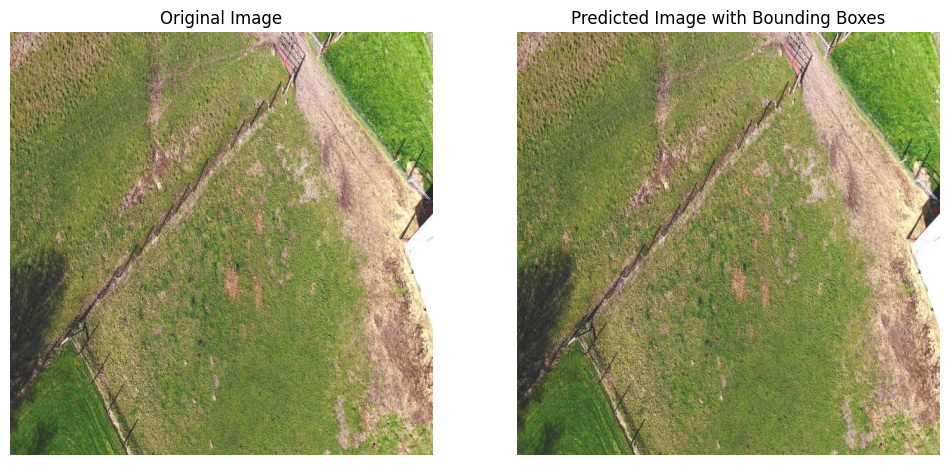

In [6]:
# Import required libraries
import cv2
import os
import yaml
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths for the trained model and test image
trained_model_path = "/content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/weights/best.pt"
test_image_path = "/content/drive/MyDrive/WAID.v1i.yolov9/test/images/img_2261_jpg.rf.a3bb92a79bd0b8e4829112b26acbf998.jpg"
dataset_yaml_path = "/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml"

# Load class names from the dataset YAML file
with open(dataset_yaml_path, "r") as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
class_names = yaml_data["names"]

# Load YOLOv9 model
model = YOLO(trained_model_path)

# Function to preprocess an image
def preprocess_image(image_path, img_size=(640, 640)):
    """
    Preprocess the input image: resize and normalize.
    Args:
        image_path (str): Path to the image.
        img_size (tuple): Target size for resizing (width, height).
    Returns:
        preprocessed_img (numpy array): Preprocessed image.
        original_img (numpy array): Original image.
    """
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Image not found at {image_path}")

    # Convert BGR to RGB
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image
    img_resized = cv2.resize(original_img, img_size)
    preprocessed_img = img_resized / 255.0  # Normalize to [0,1]

    return preprocessed_img, original_img

# Function to visualize predictions
def visualize_predictions(original_img, predictions):
    """
    Visualize predictions on the original image.
    Args:
        original_img (numpy array): Original image.
        predictions (list): List of predictions from YOLO model.
    """
    img_with_boxes = original_img.copy()

    for pred in predictions:
        x1, y1, x2, y2 = map(int, pred["box"])  # Bounding box coordinates
        class_idx = int(pred["class_idx"])
        confidence = pred["confidence"]
        label = class_names[class_idx]  # Get class name

        # Draw bounding box
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label and confidence score
        text = f"{label} ({confidence:.2f})"
        cv2.putText(img_with_boxes, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_boxes)
    plt.title("Predicted Image with Bounding Boxes")
    plt.axis("off")

    plt.show()

# Preprocess the test image
preprocessed_img, original_img = preprocess_image(test_image_path)

# Run inference on the test image
results = model.predict(
    source=test_image_path,  # Use correct variable
    imgsz=640,               # Ensure the correct image size
    conf=0.25,               # Confidence threshold
    iou=0.45,                # IoU threshold for NMS
    device=0                 # Use GPU (set to "cpu" for CPU inference)
)

# Parse predictions
predictions = []
for result in results[0].boxes:
    predictions.append({
        "box": result.xyxy[0].tolist(),        # Bounding box coordinates
        "class_idx": int(result.cls[0].item()),  # Class index
        "confidence": float(result.conf[0].item())  # Confidence score
    })

# Visualize predictions
visualize_predictions(original_img, predictions)


image 1/1 /content/drive/MyDrive/WAID.v1i.yolov9/test/images/DJI_0395_MP4-0003_jpg.rf.d2efec420aed1e8e486604554f64e847.jpg: 640x640 7 elephants, 40.3ms
Speed: 2.2ms preprocess, 40.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


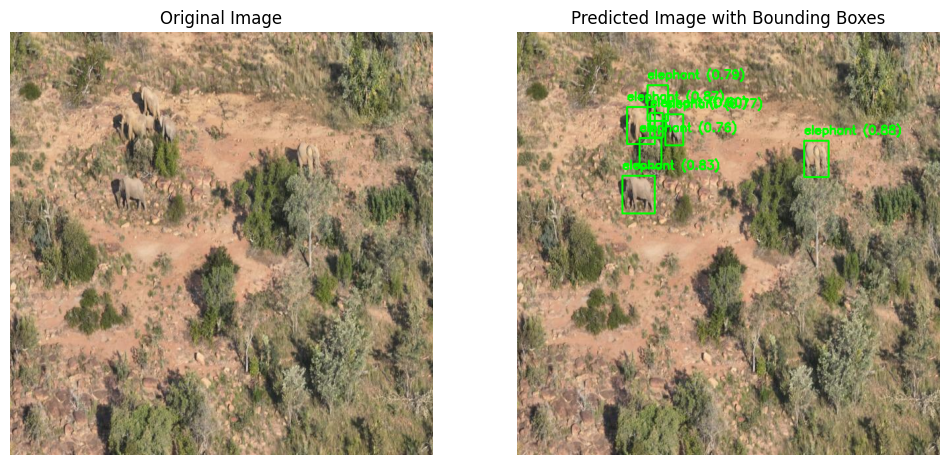

In [39]:
# Import required libraries
import cv2
import os
import yaml
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths for the trained model and test image
trained_model_path = "/content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/weights/best.pt"
test_image_path = "/content/drive/MyDrive/WAID.v1i.yolov9/test/images/DJI_0395_MP4-0003_jpg.rf.d2efec420aed1e8e486604554f64e847.jpg"
dataset_yaml_path = "/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml"

# Load class names from the dataset YAML file
with open(dataset_yaml_path, "r") as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
class_names = yaml_data["names"]

# Load YOLOv9 model
model = YOLO(trained_model_path)

# Function to preprocess an image
def preprocess_image(image_path, img_size=(640, 640)):
    """
    Preprocess the input image: resize and normalize.
    Args:
        image_path (str): Path to the image.
        img_size (tuple): Target size for resizing (width, height).
    Returns:
        preprocessed_img (numpy array): Preprocessed image.
        original_img (numpy array): Original image.
    """
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Image not found at {image_path}")

    # Convert BGR to RGB
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize and normalize image
    img_resized = cv2.resize(original_img, img_size)
    preprocessed_img = img_resized / 255.0  # Normalize to [0,1]

    return preprocessed_img, original_img

# Function to visualize predictions
def visualize_predictions(original_img, predictions):
    """
    Visualize predictions on the original image.
    Args:
        original_img (numpy array): Original image.
        predictions (list): List of predictions from YOLO model.
    """
    img_with_boxes = original_img.copy()

    for pred in predictions:
        x1, y1, x2, y2 = map(int, pred["box"])  # Bounding box coordinates
        class_idx = int(pred["class_idx"])
        confidence = pred["confidence"]
        label = class_names[class_idx]  # Get class name

        # Draw bounding box
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label and confidence score
        text = f"{label} ({confidence:.2f})"
        cv2.putText(img_with_boxes, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_with_boxes)
    plt.title("Predicted Image with Bounding Boxes")
    plt.axis("off")

    plt.show()

# Preprocess the test image
preprocessed_img, original_img = preprocess_image(test_image_path)

# Run inference on the test image
results = model.predict(
    source=test_image_path,  # Use correct variable
    imgsz=640,               # Ensure the correct image size
    conf=0.25,               # Confidence threshold
    iou=0.45,                # IoU threshold for NMS
    device=0                 # Use GPU (set to "cpu" for CPU inference)
)

# Parse predictions
predictions = []
for result in results[0].boxes:
    predictions.append({
        "box": result.xyxy[0].tolist(),        # Bounding box coordinates
        "class_idx": int(result.cls[0].item()),  # Class index
        "confidence": float(result.conf[0].item())  # Confidence score
    })

# Visualize predictions
visualize_predictions(original_img, predictions)

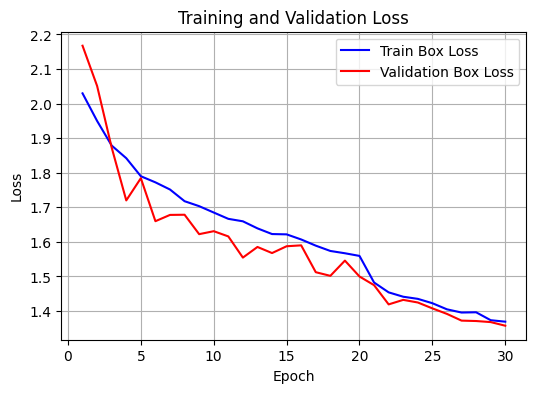

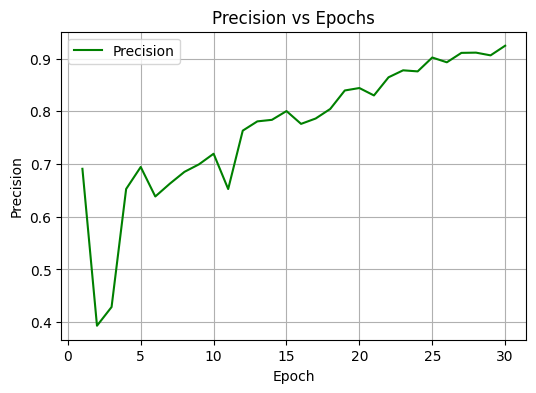

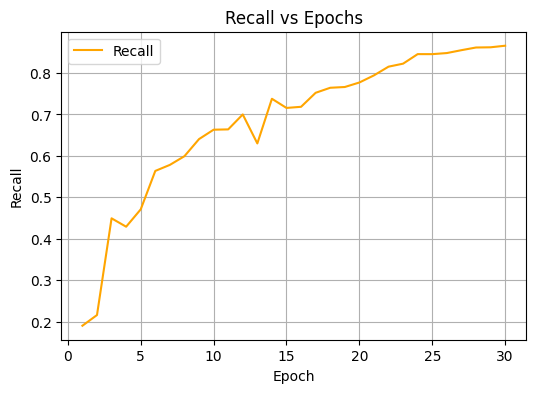

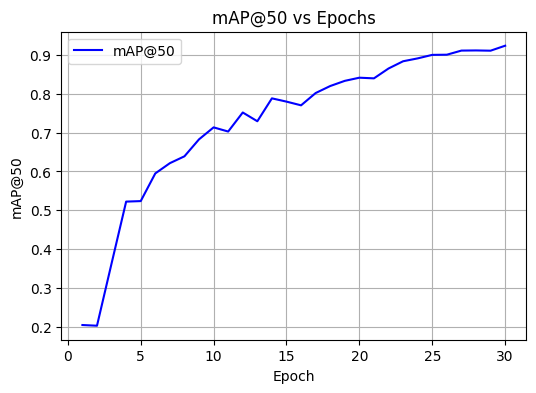

Final Performance Metrics:
  - Precision: 0.9244
  - Recall: 0.8656
  - mAP@50: 0.9235
  - Final Training Loss: 1.3692
  - Final Validation Loss: 1.3575


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Path to your results.csv file
results_path = '/content/trained_model/yolov9_optimized/results.csv'

# Load the CSV file
eval_data = pd.read_csv(results_path)

# Function to plot loss curves
def plot_loss_curves(eval_data):
    epochs = eval_data['epoch']

    # Plot training loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, eval_data['train/box_loss'], label='Train Box Loss', color='blue')
    plt.plot(epochs, eval_data['val/box_loss'], label='Validation Box Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot precision, recall, and mAP
def plot_precision_recall_mAP(eval_data):
    epochs = eval_data['epoch']

    # Plot Precision
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, eval_data['metrics/precision(B)'], label='Precision', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Recall
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, eval_data['metrics/recall(B)'], label='Recall', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot mAP
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, eval_data['metrics/mAP50(B)'], label='mAP@50', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('mAP@50')
    plt.title('mAP@50 vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to display final metrics
def display_final_metrics(eval_data):
    precision = eval_data['metrics/precision(B)'].iloc[-1]
    recall = eval_data['metrics/recall(B)'].iloc[-1]
    mAP = eval_data['metrics/mAP50(B)'].iloc[-1]
    train_loss = eval_data['train/box_loss'].iloc[-1]
    val_loss = eval_data['val/box_loss'].iloc[-1]

    print(f"Final Performance Metrics:")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - mAP@50: {mAP:.4f}")
    print(f"  - Final Training Loss: {train_loss:.4f}")
    print(f"  - Final Validation Loss: {val_loss:.4f}")

# Plotting the loss curves, precision, recall, and mAP
plot_loss_curves(eval_data)
plot_precision_recall_mAP(eval_data)

# Display final metrics
display_final_metrics(eval_data)

In [ ]:
import cv2
import os
import yaml
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # Colab-friendly imshow

# Paths
model_path = "/content/trained_model/yolov9_training/weights/best.pt"  # Path to trained model
dataset_yaml_path = "/content/drive/MyDrive/WAID.v1i.yolov9/data.yaml"  # Dataset YAML file
video_dir = "/content/drive/MyDrive/VIDEOS"  # Directory containing videos
output_dir = "/content/drive/MyDrive/WAID.v1i.yolov9/VIDEOS/output_videos"  # Directory to save output videos

# Load class names from dataset YAML file
with open(dataset_yaml_path, "r") as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
class_names = yaml_data["names"]

# Load YOLOv9 model
model = YOLO(model_path)

# Function to process videos
def process_video(video_path, output_path, show_every_n=10):
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define output video writer
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0  # To keep track of frames

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Perform YOLOv9 inference
        results = model.predict(frame, imgsz=640, conf=0.25, iou=0.45, device=0)

        # Draw bounding boxes on the frame
        for result in results[0].boxes:
            x1, y1, x2, y2 = map(int, result.xyxy[0].tolist())  # Bounding box coordinates
            class_idx = int(result.cls[0].item())  # Class index
            confidence = result.conf[0].item()  # Confidence score
            label = f"{class_names[class_idx]} ({confidence:.2f})"

            # Draw the bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Put the label
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Write frame to output video
        out.write(frame)

        # Show only every Nth frame to avoid Colab output buffer overflow
        if frame_count % show_every_n == 0:
            cv2_imshow(frame)

        frame_count += 1

    cap.release()
    out.release()

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process videos from 'test_videos' and 'captured_videos'
for subfolder in ["test_videos", "captured_videos"]:
    video_folder = os.path.join(video_dir, subfolder)
    for video_file in os.listdir(video_folder):
        if video_file.endswith((".mp4", ".avi", ".mov")):
            input_video_path = os.path.join(video_folder, video_file)
            output_video_path = os.path.join(output_dir, f"detected_{video_file}")
            print(f"Processing: {input_video_path} → {output_video_path}")
            process_video(input_video_path, output_video_path)

print("Processing complete. Check the output folder for results!")

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, width=600):
    video_file = open(video_path, "rb").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f'<video width={width} controls><source src="{video_url}" type="video/mp4"></video>')

# Example: Show the detected video
video_path = "/content/drive/MyDrive/WAID.v1i.yolov9/VIDEOS/output_videos/detected_zebras.mp4"
show_video(video_path)

In [ ]:
# prompt: how to copy a file in colab

!cp /content/trained_model.zip /content/drive/MyDrive


In [ ]:
# prompt: how to zip a folder

!zip -r /content/drive/MyDrive/yolov9_miniproject/trained_model.zip /content/trained_model


  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/yolov9_optimized/ (stored 0%)
  adding: content/trained_model/yolov9_optimized/events.out.tfevents.1740504326.ee9a0bba832f.1171.0 (deflated 94%)
  adding: content/trained_model/yolov9_optimized/val_batch2_labels.jpg (deflated 7%)
  adding: content/trained_model/yolov9_optimized/F1_curve.png (deflated 5%)
  adding: content/trained_model/yolov9_optimized/confusion_matrix_normalized.png (deflated 21%)
  adding: content/trained_model/yolov9_optimized/val_batch1_labels.jpg (deflated 6%)
  adding: content/trained_model/yolov9_optimized/weights/ (stored 0%)
  adding: content/trained_model/yolov9_optimized/weights/last.pt (deflated 7%)
  adding: content/trained_model/yolov9_optimized/weights/best.pt (deflated 7%)
  adding: content/trained_model/yolov9_optimized/val_batch2_pred.jpg (deflated 6%)
  adding: content/trained_model/yolov9_optimized/labels.jpg (deflated 30%)
  adding: content/trained_model/yolov9_optimized/t

In [ ]:
!unzip /content/drive/MyDrive/yolov9_miniproject/trained_model.zip -d /content/drive/MyDrive/yolov9_miniproject/trained_model


Archive:  /content/drive/MyDrive/yolov9_miniproject/trained_model.zip
   creating: /content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/
   creating: /content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/
  inflating: /content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/events.out.tfevents.1740504326.ee9a0bba832f.1171.0  
  inflating: /content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/val_batch2_labels.jpg  
  inflating: /content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/F1_curve.png  
  inflating: /content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/confusion_matrix_normalized.png  
  inflating: /content/drive/MyDrive/yolov9_miniproject/trained_model/content/trained_model/yolov9_optimized/val_batch1_labels.jpg  
   creating: /content/drive/MyDrive/yol

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"